In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
from datetime import timedelta
import os
import sys
sys.path.append('../../src')
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from aosol.armazenamento import bateria
from IPython.display import HTML, display, display_html

# Analise de UPAC

Analise de um projecto de UPAC com dados de consumo obtidos do portal e-redes, dados de produção obtidos da plataforma PVGIS e subsequente análise dos indicadores principais do projecto: indice auto consumo (IAC), indice de auto suficiência (IAS) e indice entrega à rede (IER). É feita também uma análise financeiro do projecto.

In [2]:
# Parametros do projecto
nome_projecto = 'Exemplo_600W'
# =====================
# Consumo
# =====================
ano_consumo = 2023
perfil = 'BTN C' # ver na document
consumo_anual = 2400 # kWh, exemplo consumo médio 200 kWh/mes
fich_perfil_eredes = r"./consumo/perfis_eredes/E-REDES_Perfil_Consumo_2023.csv"

# =====================
# Producao
# =====================
capacidade_instalada = 0.6 # em kW
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
inicio_ano_pvgis = 2005
fim_ano_pvgis = 2023 # PVGIS-SARAH3 na V5.3 (2005-2023)
lat = 38.716
lon = -9.148
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %

# =====================
# Analise energetica
# =====================
analise_com_bateria = False
capacidade_bat = 1.2 # kWh
soc_min = 20 # limite maximo descarregamento em % 
soc_max = 80 # limite maximo carregamento em %

# =====================
# Analise poupanca anual
# =====================
ano_tarifario = 2023
simples_kwh = 0.15826 # simples
bihorario_fora_vazio_kwh = 0.1859
bihorario_vazio_kwh = 0.0988
trihorario_ponta_kwh = 0.2278
trihorario_cheias_kwh = 0.1638
trihorario_vazio_kwh = 0.0988
# venda a rede com preco fixo
preco_venda_rede = 0.06 # 6cent/kWh
precos_energia = ape.TarifarioEnergia(simples_kwh, \
    bihorario_fora_vazio_kwh, bihorario_vazio_kwh, \
    trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, \
    preco_venda_rede)

# =====================
# Analise tempo de vida
# =====================
tempo_vida = 25 # anos
ano_0 = 2023 # ano 0 do projecto
taxa_actualizacao = 5 # em %
taxa_degradacao_sistema = 0.7 # %/ano
taxa_inflacao = 2.0 # %/ano

# Custos do projecto
total = 1500 # €
# investimento_estimado = pv + instalacao + outros_custos
custo_pv = total * 0.6 # 60% material
custo_instalacao = total * 0.3 # 30% instalacao
outros_custos = total * 0.1 # 10% outros custos
# custo manutencao anual como percentagem do investimento
perc_custo_manutencao = 0.5 # em %
# apoio estatal (fundo ambiental)
considerar_apoio = False
perc_apoio = 85 # em % do investimento estimado
apoio_max = 2500 # em €, valor maximo pago pelo fundo

## 1. Consumo

Utilização de perfil médio da e-redes

In [3]:
perfil_eredes = series.leitura_perfis_eredes(fich_perfil_eredes, perfil)
consumo = series.ajustar_perfil_eredes_a_consumo_anual(perfil_eredes, consumo_anual, 'BTN C', 'consumo')

Consumo anual = 2400.0 kWh


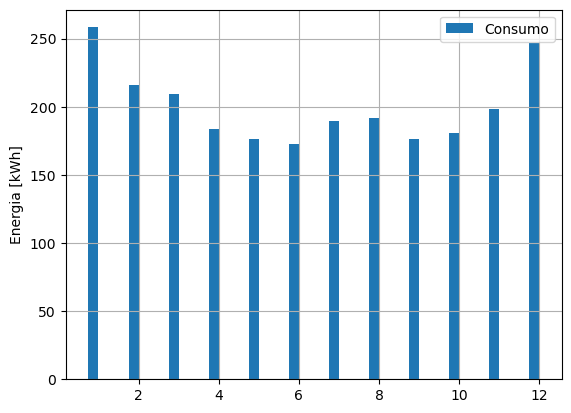

In [4]:
consumo_mensal = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(consumo_mensal.index.month-width/2, consumo_mensal, width=width, label='Consumo')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

## 2. Produção

Produção estimada através do PV GIS

In [5]:
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

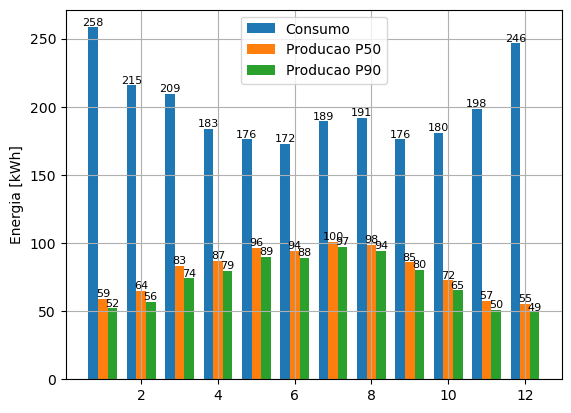

In [6]:
producao_mensal = producao.resample('M').sum()

fig, ax = plt.subplots()

width = 0.50
c = ax.bar(consumo_mensal.index.month-width/2, consumo_mensal, width=width/2, label='Consumo')
ax.bar_label(c, fmt='%d', fontsize=8)
p = ax.bar(producao_mensal.index.month, producao_mensal['autoproducao'], width=width/2, label='Producao P50')
ax.bar_label(p, fmt='%d', fontsize=8)
p1 = ax.bar(producao_mensal.index.month+width/2, producao_mensal['autoproducao_p90'], width=width/2, label='Producao P90')
ax.bar_label(p1, fmt='%d', fontsize=8)
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

## 3. Análise energética do projecto

Analisar projecto de UPAC sem armazenamento através dos seguintes indicadores

* Indice de auto consumo : fraccao da producao que é consumida

* Indice de auto suficiencia : fracao do consumo que é suprida pela producao

* Indice de entrega a rede : fraccao da producao que nao e consumida e é entregue a rede

In [7]:
# juntar consumo com autoproducao na mesma frame
energia = consumo['consumo'].to_frame('consumo')
energia = energia.join(producao, how="outer")

# calcula upac sem armazenamento
energia = ae.analisa_upac_sem_armazenamento(energia)

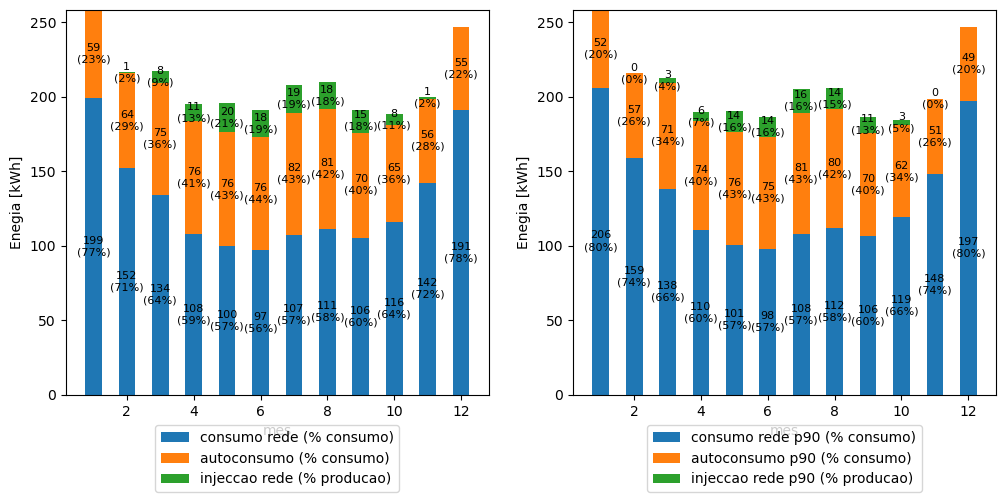

In [8]:
energia_mensal = energia.resample('M').sum()

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# plot mean P50
ae.plot_energia_mensal_bars(ax1, energia_mensal, consumo_mensal, producao_mensal["autoproducao"], ["consumo_rede", "autoconsumo", "injeccao_rede"])

# plot P90
ae.plot_energia_mensal_bars(ax2, energia_mensal, consumo_mensal, producao_mensal["autoproducao_p90"], ["consumo_rede_p90", "autoconsumo_p90", "injeccao_rede_p90"])


In [9]:
indicadores, indicadores_p90 = ae.calcula_indicadores_autoconsumo(energia, capacidade_instalada, True)
ae.print_tabela_indicadores_html(indicadores, indicadores_p90)

,P50,P90
Potencia Instalada,0.60 kW,0.60 kW
Energia Autoproduzida [kWh],955.4,878.1
Energia Autoconsumida [kWh],835.4,797.1
Energia consumida rede [kWh],1564.6,1602.9
Energia consumida [kWh],2400.0,2400.0
Numero de horas equivalentes [h/ano],1592.4,1463.5
IAS: Contributo PV [%],34.8,33.2
IAC: Indice Auto consumo [%],87.4,90.8
IER: Producao PV desperdicada [%],12.6,9.2


## 4. Análise de poupanca anual

Custos mensais por tipo tarifario.

### 4.1 UPAC sem venda à rede

#### Tarifário Simples

In [10]:
mensal_simples = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Simples, precos_energia, False, ['consumo', 'consumo_rede'])
simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

mensal_simples_p90 = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Simples, precos_energia, False, ['consumo', 'consumo_rede_p90'])
simples_styler_p90 = mensal_simples_p90.style.format("{:.2f} €").set_caption('Tarifario Simples P90').set_table_attributes("style='display:inline'")
display_html(simples_styler._repr_html_() + simples_styler_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,52.07 €,40.49 €,11.58 €
Fevereiro,43.90 €,31.45 €,12.45 €
Março,42.53 €,27.76 €,14.77 €
Abril,37.54 €,22.72 €,14.82 €
Maio,35.99 €,21.07 €,14.92 €
Junho,35.41 €,20.62 €,14.79 €
Julho,38.55 €,22.52 €,16.03 €
Agosto,39.07 €,23.25 €,15.82 €
Setembro,36.01 €,22.21 €,13.80 €


#### Tarifário Bi-horário

In [11]:
mensal_bihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Bihorario, precos_energia, False, ['consumo', 'consumo_rede'])
bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

mensal_bihorario_p90 = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Bihorario, precos_energia, False, ['consumo', 'consumo_rede_p90'])
bihorario_styler_p90 = mensal_bihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P90').set_table_attributes("style='display:inline'")
display_html(bihorario_styler._repr_html_() + bihorario_styler_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,51.77 €,38.27 €,13.50 €
Fevereiro,43.45 €,28.96 €,14.49 €
Março,42.25 €,25.18 €,17.07 €
Abril,37.30 €,20.32 €,16.98 €
Maio,35.71 €,18.69 €,17.02 €
Junho,35.00 €,18.18 €,16.82 €
Julho,38.08 €,19.79 €,18.29 €
Agosto,38.60 €,20.50 €,18.10 €
Setembro,35.67 €,19.85 €,15.82 €


#### Tarifário Tri-horário

In [12]:
mensal_trihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Trihorario, precos_energia, False, ['consumo', 'consumo_rede'], ano_tarifario)
trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

mensal_trihorario_p90 = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Trihorario, precos_energia, False, ['consumo', 'consumo_rede_p90'], ano_tarifario)
trihorario_style_p90 = mensal_trihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P90').set_table_attributes("style='display:inline'")
display_html(trihorario_style._repr_html_() + trihorario_style_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,59.70 €,44.10 €,15.60 €
Fevereiro,49.93 €,33.20 €,16.73 €
Março,47.17 €,27.11 €,20.06 €
Abril,37.04 €,16.71 €,20.33 €
Maio,35.14 €,15.23 €,19.91 €
Junho,34.30 €,14.61 €,19.69 €
Julho,37.18 €,15.70 €,21.48 €
Agosto,37.72 €,16.31 €,21.41 €
Setembro,35.10 €,16.18 €,18.92 €


### 4.2 UPAC com venda à rede

#### Tarifário Simples

In [13]:
mensal_simples = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Simples, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

mensal_simples_p90 = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Simples, precos_energia, True, ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90'])
simples_styler_p90 = mensal_simples_p90.style.format("{:.2f} €").set_caption('Tarifario Simples P90').set_table_attributes("style='display:inline'")
display_html(simples_styler._repr_html_() + simples_styler_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,52.07 €,40.65 €,11.42 €,0.00 €
Fevereiro,43.90 €,31.35 €,12.62 €,0.07 €
Março,42.53 €,27.72 €,15.31 €,0.50 €
Abril,37.54 €,22.72 €,15.55 €,0.73 €
Maio,35.99 €,21.08 €,16.13 €,1.22 €
Junho,35.41 €,20.61 €,15.92 €,1.12 €
Julho,38.55 €,22.54 €,17.14 €,1.13 €
Agosto,39.07 €,23.26 €,16.89 €,1.08 €
Setembro,36.01 €,22.17 €,14.81 €,0.97 €


#### Tarifário Bi-horário

In [14]:
mensal_bihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Bihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'])
bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

mensal_bihorario_p90 = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Bihorario, precos_energia, True, ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90'])
bihorario_styler_p90 = mensal_bihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Bi-horário P90').set_table_attributes("style='display:inline'")
display_html(bihorario_styler._repr_html_() + bihorario_styler_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,51.77 €,38.46 €,13.31 €,0.00 €
Fevereiro,43.45 €,28.84 €,14.68 €,0.07 €
Março,42.25 €,25.12 €,17.63 €,0.50 €
Abril,37.30 €,20.31 €,17.72 €,0.73 €
Maio,35.71 €,18.70 €,18.23 €,1.22 €
Junho,35.00 €,18.17 €,17.95 €,1.12 €
Julho,38.08 €,19.80 €,19.41 €,1.13 €
Agosto,38.60 €,20.50 €,19.18 €,1.08 €
Setembro,35.67 €,19.81 €,16.83 €,0.97 €


#### Tarifário Tri-horário

In [15]:
mensal_trihorario = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Trihorario, precos_energia, True, ['consumo', 'consumo_rede', 'injeccao_rede'], ano_tarifario)
trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

mensal_trihorario_p90 = af.analise_poupanca_anual_fatura(energia, ape.Tarifario.Trihorario, precos_energia, True, ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90'], ano_tarifario)
trihorario_style_p90 = mensal_trihorario_p90.style.format("{:.2f} €").set_caption('Tarifario Tri-horário P90').set_table_attributes("style='display:inline'")
display_html(trihorario_style._repr_html_() + trihorario_style_p90._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,59.70 €,44.38 €,15.32 €,0.00 €
Fevereiro,49.93 €,33.12 €,16.88 €,0.07 €
Março,47.17 €,27.06 €,20.61 €,0.50 €
Abril,37.04 €,16.70 €,21.07 €,0.73 €
Maio,35.14 €,15.23 €,21.13 €,1.22 €
Junho,34.30 €,14.59 €,20.83 €,1.12 €
Julho,37.18 €,15.70 €,22.61 €,1.13 €
Agosto,37.72 €,16.31 €,22.49 €,1.08 €
Setembro,35.10 €,16.16 €,19.91 €,0.97 €


## 5. Analise Financeira do projecto no tempo de vida

Calcular indicadores financeiros para o tempo de vida do projecto.

* VAL

* TIR

* Tempo retorno projecto

In [13]:
investimento_estimado = custo_pv + custo_instalacao + outros_custos

# Custo de manutencao anual
custo_manutencao = investimento_estimado * (perc_custo_manutencao / 100)

# Apoio fundo ambiental
apoio = 0
if considerar_apoio:
   apoio = min(investimento_estimado*(perc_apoio/100), apoio_max)
   investimento_estimado = investimento_estimado - apoio

### 5.1 UPAC sem venda à rede

In [14]:
cols = ['consumo', 'consumo_rede']
cols_p90 = ['consumo', 'consumo_rede_p90']

indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, False, cols, indicadores)
simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

indicadores_financas_simples_p90, cf_simples_p90 = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, False, cols_p90, indicadores)
simples_style_p90 = indicadores_financas_simples_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P90').set_table_attributes("style='display:inline'")
display_html(simples_style._repr_html_() + simples_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1005.80
TIR [%],10.57
Retorno do investimento [anos],12.20
Lcoe [€/kWh],0.13
,valores
indice,


In [16]:
# custos tarifario bi-horario
indicadores_financas_bihorario, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, False, cols, indicadores)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

indicadores_financas_bihorario_p90, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, False, cols_p90, indicadores)
bihorario_style_p90 = indicadores_financas_bihorario_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P90').set_table_attributes("style='display:inline'")
display_html(bihorario_style._repr_html_() + bihorario_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1368.35
TIR [%],12.40
Retorno do investimento [anos],10.30
Lcoe [€/kWh],0.13
,valores
indice,


In [19]:
# custos tarifario tri-horario
indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, False, cols, indicadores)
trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

indicadores_financas_trihorario_p90, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, False, cols_p90, indicadores)
trihorario_style_p90 = indicadores_financas_trihorario_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P90').set_table_attributes("style='display:inline'")

display_html(trihorario_style._repr_html_() + trihorario_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1948.26
TIR [%],15.09
Retorno do investimento [anos],8.30
Lcoe [€/kWh],0.13
,valores
indice,


### 5.2 UPAC com venda à rede

In [17]:
cols = ['consumo', 'consumo_rede', 'injeccao_rede']
cols_p90 = ['consumo', 'consumo_rede_p90', 'injeccao_rede_p90']

# custos tarifario simples
indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, True, cols, indicadores)
simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P50').set_table_attributes("style='display:inline'")

indicadores_financas_simples_p90, cf_simples_p90 = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, True, cols_p90, indicadores)
simples_style_p90 = indicadores_financas_simples_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples P90').set_table_attributes("style='display:inline'")
display_html(simples_style._repr_html_() + simples_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1120.84
TIR [%],11.15
Retorno do investimento [anos],11.50
Lcoe [€/kWh],0.13
,valores
indice,


In [18]:
# custos tarifario bi-horario
indicadores_financas_bihorario, cf_bihorario = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, True, cols, indicadores)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P50').set_table_attributes("style='display:inline'")

indicadores_financas_bihorario_p90, cf_bihorario_p90 = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, True, cols_p90, indicadores)
bihorario_style_p90 = indicadores_financas_bihorario_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário P90').set_table_attributes("style='display:inline'")
display_html(bihorario_style._repr_html_() + bihorario_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1483.39
TIR [%],12.95
Retorno do investimento [anos],9.80
Lcoe [€/kWh],0.13
,valores
indice,


In [19]:
# custos tarifario tri-horario
indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, True, cols, indicadores)
trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P50').set_table_attributes("style='display:inline'")

indicadores_financas_trihorario_p90, _ = af.analise_financeira_projecto_faturas(energia, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, True, cols_p90, indicadores)
trihorario_style_p90 = indicadores_financas_trihorario_p90.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário P90').set_table_attributes("style='display:inline'")

display_html(trihorario_style._repr_html_() + trihorario_style_p90._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],2060.43
TIR [%],15.60
Retorno do investimento [anos],8.00
Lcoe [€/kWh],0.13
,valores
indice,
